# Tutorial 3b. Multilayer Perceptrons with Auto-differentiation!

- In this tutorial you will train (again) a multilayer perceptron

- But differently from what you did in `tutorial3a`, since this time, you will let the `PyTorch` library do most of the complicated work for you

- The goal of this notebook is to make you get familiar with `PyTorch` and the its main concepts, that we will use repeatedly along the course.

- We will be training a multilayer perceptron on the `CIFAR-10` dataset, a popular dataset of images that is used in Computer-Vision (CV) research

- You will need to use a lot the documentation of `PyTorch` and look at examples for this notebook.

In [2]:
import torch, torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt 

## Load the dataset

- `PyTorch` provides popular computer vision datasets that can be easily downloaded
- The following code will download the `CIFAR-10` dataset for us  
- Since it is computationally expensive to load the entire dataset into memory, we will use `PyTorch`'s dataloaders  before feeding batches of images to the neural network

**QUESTION.** Fill in the next cell

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
testset = datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)

batch_size = 128
# You should use as many cores you have on your laptop
num_workers = 4

# Fill in the options for both data loaders. Warning: the training dataloader should shuffle the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualize the Images of CIFAR-10

* Once everything is properly loaded you should be able to visualize some of the samples of the CIFAR-10

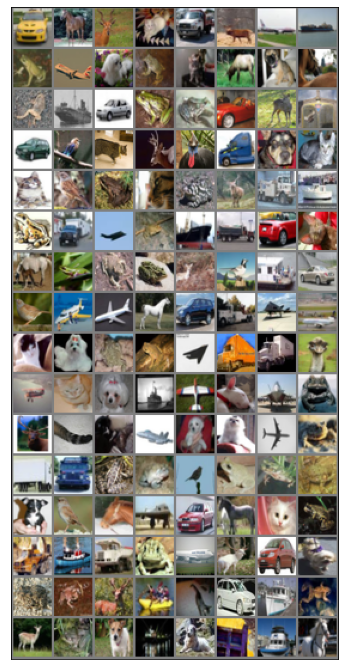

  car horse  deer   cat truck  deer plane  ship  frog plane   dog  frog   cat  deer   dog horse  frog  ship   car  frog  frog   car  deer truck   car  bird   cat  deer  bird truck   dog   cat   cat  bird  frog   cat  frog  deer truck  ship  frog truck plane  frog  ship truck   car   cat horse  frog  frog  frog  deer  bird  ship   car  bird plane plane horse   car truck plane plane   cat   dog  frog  frog plane truck truck  bird plane   cat   dog  ship plane   dog plane  frog  deer   cat   cat plane   dog   dog plane  frog truck truck  frog  frog  bird  frog  frog  frog   dog  bird horse plane   car horse   cat  frog truck  ship truck  frog plane  deer   car   dog  frog  frog  deer  ship   cat   car  ship  frog  deer  frog   dog  ship   dog truck  ship horse


In [4]:
def show_images(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Creating a MLP model and train it

- We are now ready to define all the necessary hyperparameters that are required to construct a proper MLP
- Similarly to what we did in `tutorial03a` we need to explore the data carefully in order to know how to set the following parameters

### Hyperparameters

**QUESTION.** Fill the hyperparameters

In [5]:
img, label = trainset[0]
img.shape

torch.Size([3, 32, 32])

The size of the tensors is [3, 32, 32], so the input dimension is 3x32x32.

The model aims to classify an image among 10 classes, so the output dimension is 10.

Concerning the dimension of the hidden layers, the learning rate and the number of epochs, they were fixed after evaluating the performance of the model with different values for each of them.

In [6]:
input_dim = 3*32*32
hidden_dim = [1024,512,64]
output_dim = 10
learning_rate = 1e-4
num_epochs = 10

### Computation Graph

- You are free to define any kind of architecture that you think is reasonable for the problem of classifying CIFAR-10 images
- By default, you can use a multi-layer perceptron
- The constructor of the neural network will represent the different components of the computation-graph, note that it is very similar to the way we have programmed our own neural network in `tutorial03a`.
- You will also have to define the forward pass yourself.

In [7]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim[0])
        self.linear2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.linear3 = nn.Linear(hidden_dim[1], hidden_dim[2])
        self.linear4 = nn.Linear(hidden_dim[2], hidden_dim[2])
        self.linear5 = nn.Linear(hidden_dim[2], output_dim)
        
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

### Create the Network

- You are now ready to create your neural network object
- You will also have to define an appropriate loss function to minimize and an optimization algorithm
- By default, you can use the cross-entropy loss and the RMS prop optimizer

In [8]:
model = Net(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

### Train the Network

- Once you have your neural network you just need to train it. 
- You will have to compute the output of the forward pass, compare it to your desired output and update the parameters of the network by backpropagation. 
- Fortunately this time, this only requires less than 5 lines of code in `PyTorch`

In [9]:
def train(num_epochs):
    loss_values = []
    acc_values = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        for data in trainloader:
            features, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            pred = model(features)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            
            # loss and accuracy
            _, predicted = torch.max(pred.data, 1)           
            correct += (predicted == labels).sum().item()            
            epoch_loss += pred.shape[0]*loss.item()
            
        loss_values.append(epoch_loss / len(trainset))
        acc_values.append(correct / len(trainset))
            
        print("Epoch ",epoch+1," Train loss: ", epoch_loss/len(trainset)," Train accuracy:", correct/len(trainset))
    
    # Plot the loss values
    plt.figure(figsize=(7, 5))
    plt.plot(loss_values, lw=3, label='Training')
    plt.legend(fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    
    # Plot the accuracy values
    plt.figure(figsize=(7, 5))
    plt.plot(acc_values, lw=3, label='Training')
    plt.legend(fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    

Epoch  1  Train loss:  1.791629028930664  Train accuracy: 0.3596
Epoch  2  Train loss:  1.5339666153717042  Train accuracy: 0.4583
Epoch  3  Train loss:  1.4275227117919922  Train accuracy: 0.49764
Epoch  4  Train loss:  1.3483796725845336  Train accuracy: 0.5237
Epoch  5  Train loss:  1.2835845307159424  Train accuracy: 0.5488
Epoch  6  Train loss:  1.223517395401001  Train accuracy: 0.57116
Epoch  7  Train loss:  1.1672435550308227  Train accuracy: 0.59174
Epoch  8  Train loss:  1.1134713414764403  Train accuracy: 0.61092
Epoch  9  Train loss:  1.062486436843872  Train accuracy: 0.6284
Epoch  10  Train loss:  1.0156012015151978  Train accuracy: 0.64588


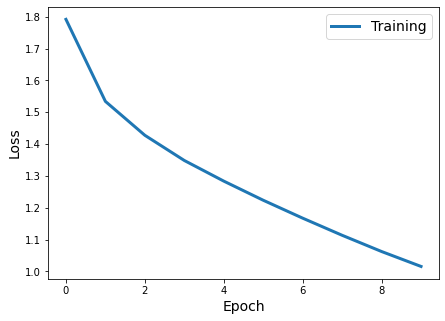

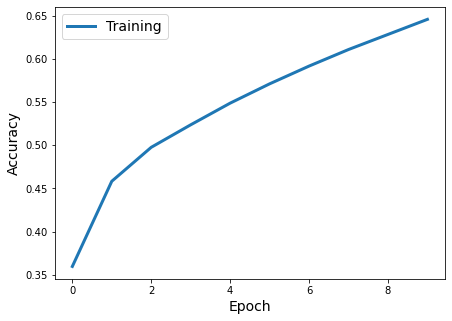

In [10]:
train(num_epochs)

- Of course, repeated calls to `train` will continue training from where it were
- Training a neural network is a highly iterative process.

## Evaluate the final performance of the Network

- Once you think your network is properly trained, you will test its performance on the testing-set of the CIFAR-10 dataset
- Compute the final accuracy of your model
- You should be able to reach a 50% accuracy with a simple multi-layer perceptron

In [10]:
def test():
    correct, total = 0, 0
    with torch.no_grad():
        for data in testloader:
            features, labels = data
            pred = model(features)
            _, predicted = torch.max(pred.data, 1)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / len(testset)))

In [12]:
test()

Accuracy of the network on the test images: 54 %


**Final remark.** Of course, this is far from being the state-of-the-art. Indeed, convolutional neural nets are the backbones for computer vision problems (we will do it in following labs), while we only used here a feed-forward network.

## Redo it using `pytorch-lightning`

There is some boilerplates in pure `PyTorch` code. The `pytorch-lighting` library is a new library allowing to simplify a lot the use of `PyTorch` together with very nice options for faster training and development.

**QUESTION**. Recode your neural network and its training using `pytorch-lightning`.

In [12]:
import pytorch_lightning as pl

In [15]:
class LightningNet(pl.LightningModule):
  
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU(), 
            nn.Linear(hidden_dim[2], hidden_dim[2]),
            nn.ReLU(), 
            nn.Linear(hidden_dim[2], output_dim)
        )
        self.ce = nn.CrossEntropyLoss() 
    
    def forward(self, x):
        return self.layers(x)
  
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.layers(x)
        loss = self.ce(y_hat, y)
    
        # training metrics
        y_hat = torch.argmax(y_hat, dim=1)
        acc = torch.sum(y == y_hat).item() / (len(y) * 1.0)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.layers(x)
        loss = self.ce(y_hat, y)
        
        y_hat = torch.argmax(y_hat, dim=1)
        accuracy = torch.sum(y == y_hat).item() / (len(y) * 1.0)
        output = dict({
            'test_loss': loss,
            'test_acc': torch.tensor(accuracy),
        })
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate)
        return optimizer
    
if __name__ == '__main__':
   
    # Init the model
    lightningModel = LightningNet(input_dim, hidden_dim, output_dim)
    
    trainer = pl.Trainer(max_epochs = num_epochs, auto_select_gpus=True)
  
    # Perform training
    trainer.fit(lightningModel, trainloader)
  
    # Perform evaluation
    trainer.test(lightningModel, testloader)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name   | Type             | Params
--------------------------------------------
0 | layers | Sequential       | 3.7 M 
1 | ce     | CrossEntropyLoss | 0     
--------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.837    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5, 'test_loss': 1.387502908706665}
--------------------------------------------------------------------------------
